In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
from numpy import nan
from numpy import isnan
from pandas import read_csv
from pandas import to_numeric
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from tensorflow import keras
import math
import matplotlib
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_error
from keras.layers import Bidirectional
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
!pip install folium==0.2.1
!pip install pdflatex
!sudo apt-get install texlive-latex-recommended 
!sudo apt install texlive-latex-extra
!sudo apt install dvipng

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load Data**

In [ ]:
df = read_csv('drive/MyDrive/House_Hold_dataset/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
df.replace('?', nan, inplace=True)
df = df.astype('float32')
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.429993,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.000000,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.820007,3.8,0.0,0.0,0.0


**filling missing data**

In [ ]:
def fill_missing(values):
  one_day=60*24
  for row in range(values.shape[0]):
    for col in range(values.shape[1]):
      if isnan(values[row,col]):
        values[row,col]= values[row- one_day,col]

In [ ]:
fill_missing(df.values)
df[df['Global_active_power'].isnull()]        

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,


In [ ]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.089561e+00,1.236733e-01,2.434321e+02,4.619704e+00,1.118474e+00,1.291131e+00,6.448635e+00
std,1.054365e+00,1.127151e-01,4.147553e+00,4.430348e+00,6.092595e+00,5.734393e+00,8.457127e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410000e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.526000e+00,1.940000e-01,2.428700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


**Daily data**

In [ ]:
daily_groups = df.resample('D')
daily_data = daily_groups.sum()
daily_data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0
...,...,...,...,...,...,...,...
2010-11-22,2041.536011,142.354004,345883.84375,8660.400391,4855.0,2110.0,10136.0
2010-11-23,1577.536011,137.449997,346428.75000,6731.200195,1871.0,458.0,7611.0
2010-11-24,1796.248047,132.460007,345644.59375,7559.399902,1096.0,2848.0,12224.0


In [ ]:
daily_data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000
mean,1567.839478,178.004837,346600.312500,6646.583008,1609.656006,1858.135254,9280.574219
std,597.306824,48.881680,7375.843750,2472.110107,1581.724731,2085.161377,3674.915527
min,250.298004,34.922001,93552.531250,1164.000000,0.000000,0.000000,1288.000000
25%,1176.195007,143.063004,345736.796875,5055.399902,700.000000,432.500000,6681.000000
50%,1543.252991,171.198997,346979.437500,6539.300049,1119.000000,696.000000,9272.000000
75%,1894.467529,202.548500,348283.375000,7965.599976,2201.750000,2732.000000,11764.000000
max,4773.386230,417.834015,356306.406250,20200.400391,11178.000000,12109.000000,23743.000000


In [ ]:
plt.style.use('tableau-colorblind10')
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'font.size':       8,
    'legend.fontsize': 8,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
})

<function matplotlib.pyplot.show>

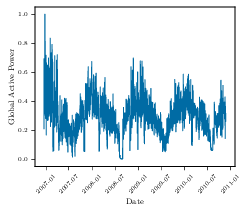

In [ ]:
plt.figure(figsize=(3.48761,3))
# plt.title("daily power consumption")
plt.plot(daily_data['Global_active_power'],linewidth=0.8)
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('fig1.pgf')
plt.show

**Split data to test and train**

In [ ]:
train_size = int(len(daily_data) * 0.80)
test_size = len(daily_data) - train_size
train, test = daily_data.iloc[0:train_size], daily_data.iloc[train_size:len(daily_data)]
print(len(train), len(test))

1153 289


In [ ]:
from sklearn.preprocessing import MinMaxScaler
f_columns = ['Global_reactive_power',	'Voltage',	'Global_intensity',	'Sub_metering_1',	'Sub_metering_2',	'Sub_metering_3']
f_transformer = MinMaxScaler()
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())

In [ ]:
cnt_transformer = MinMaxScaler()
cnt_transformer = cnt_transformer.fit(train[['Global_active_power']])
train['Global_active_power'] = cnt_transformer.transform(train[['Global_active_power']])
test['Global_active_power'] = cnt_transformer.transform(test[['Global_active_power']])

**Create Dataset**

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps),1:].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps:i + time_steps+1])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 7
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.Global_active_power, time_steps)
X_test, y_test = create_dataset(test, test.Global_active_power, time_steps)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1146, 7, 6) (1146, 1)
(282, 7, 6) (282, 1)


**Our Model**

In [ ]:
def create_model():
  model = Sequential()
  model.add(LSTM(128, activation='relu', return_sequences=True))
  model.add(LSTM(64, activation='relu', return_sequences=False))
  model.add(RepeatVector(7))
  model.add(LSTM(64, activation='relu', return_sequences=True))
  model.add(LSTM(128, activation='relu', return_sequences=True))

  model.add(Bidirectional(LSTM(128, activation='relu',return_sequences=True)))
  model.add(LSTM(64, activation='relu', return_sequences=True))
  model.add(Dropout(0.25))
  model.add(LSTM(64, activation='relu', return_sequences=False))
  model.add(Dropout(0.25))

  model.add(Dense(10,activation='relu'))
  model.add(Dense(1,activation='relu'))
  model.compile(loss='mse', optimizer='adam')
  model.build(input_shape=(None,X_train.shape[1],X_train.shape[2])) 
  model.summary()
  return model

In [ ]:
model=create_model()
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.3)
y_pred = model.predict(X_test)

**Evaluation**

In [ ]:
def MAPE_Value(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [ ]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred.reshape(1,-1))
RMSE = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
MAPE=MAPE_Value(y_test_inv,y_pred_inv)
MAE= (mean_absolute_error(y_test_inv, y_pred_inv))

In [ ]:
print('MAE is {}'.format(MAE))
print('RMSE is {}'.format(RMSE))
print('MAPE is {}'.format(MAPE))

MAE is 256.68505859375
RMSE is 355.97960132920537
MAPE is 21.2674081325531


**Plot Validation**

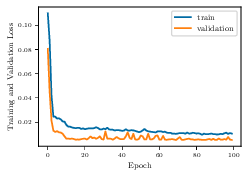

In [ ]:
plt.figure(figsize=(3.48761,2.5))
plt.plot(history.history['loss'] , label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
# plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('fig3.pgf')

**Plot Result**

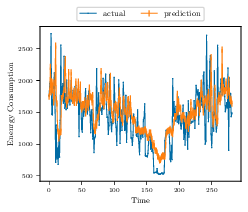

In [ ]:
plt.figure(figsize=(3.48761,3))
plt.plot(y_test_inv.flatten(), marker=',',label='true',linewidth=0.8)
plt.plot(y_pred_inv.flatten(), marker='|',label='Predicted',linewidth=0.8)
plt.xlabel('Time')
plt.ylabel(' Enenrgy Consumption')

plt.legend(['actual', 'prediction'], loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.tight_layout()
plt.show()
plt.savefig('fig5.pgf')